Character learning has two components.  First, we need to learn the structure of the automaton representing the automaton.  ProbFOIL, a relational learning library built on top of ProbLog, seems a natural choice---at any rate, it remains for future work.

Once we have a structure, we can fit parameters to that structure.  Example parameters include the dynamics of each state and any parameters on guards.  Since we only consider one character at a time, we can abstract the environment into occluding collisions, non-occluding collisions, and hostile collisions.

We'll work with non-hierarchical, non-concurrent hybrid automata for now.  Also, we'll assume left and right movement are mirrored.  Our representation of a state will define, for each variable, whether it has a constant velocity or a constant acceleration (and what that value is); and what transitions are available under what circumstances (a conjunction of abstracted inputs, continuous variable thresholds, timers, any collisions of any type at any normal to the character, and negations of the same).  A state machine is a set of states and an initial state.

In [1]:
%matplotlib inline

import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns
#from ipywidgets import interactive, fixed

import numpy as np
import pandas as pd


import theano

import jumpfinder
from jumpfinder import hold, marioGetX, marioGetY, metroidGetX, metroidGetY
import fceulib

/Users/jcosborn/.virtualenvs/mechlearn/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
RIGHT = 1 << 7
LEFT = 1 << 6
DOWN = 1 << 5
UP = 1 << 4
START = 1 << 3
SELECT = 1 << 2
B = 1 << 1
A = 1 << 0

mario_x = 0x006D
mario_y = 0x00CE

metroid_x = 0x0051
metroid_y = 0x0052

In [3]:
jumpButton = A
games = {
    "mario": (
        "mario.nes",
        (hold(0x0, 120) + hold(START | jumpButton, 30) +
         hold(0x0, 150)),
        marioGetX,
        marioGetY
    ),
    "metroid": (
        "metroid.nes",
        (hold(0x0, 60) + hold(START, 1) + hold(0x0, 15) +
         hold(START, 1) + hold(0x0, 600) + hold(LEFT, 400) +
         hold(RIGHT, 30)),
        metroidGetX,
        metroidGetY
    )
}
# CHANGE GAME HERE
(game, startInputs, getx, gety) = games["metroid"]
total = 0
emu = fceulib.runGame(game)
for m in startInputs:
    total = total + 1
    emu.step(m, 0x0)

emu.step(0x0, 0x0)
start = fceulib.VectorBytes()
emu.save(start)
trials = jumpfinder.runTrials(emu, start, getx, gety, jumpButton)

Let's learn three linear-or-constant velocity models.

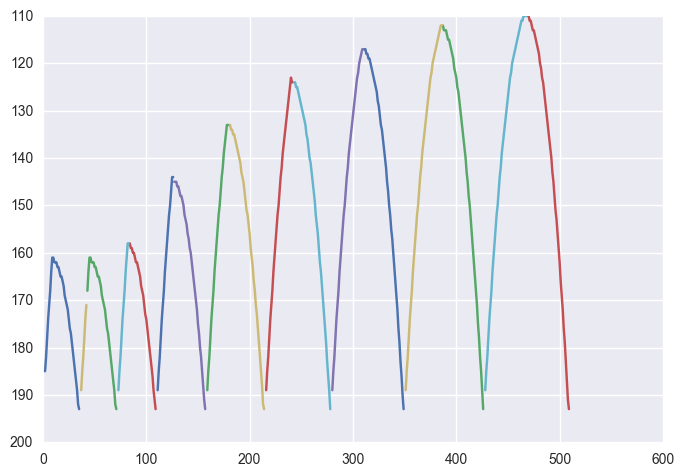

In [28]:
mode_names = ["ground", "rise", "fall"]
modes = dict()
for m in mode_names:
    modes[m] = []

def record_run(modes, state, t, prev_vbls, vbls):
    frame = pd.DataFrame(vbls)
    modes[state].append((t, prev_vbls, frame))

t = 0
state_change_t = 0
# Tweak the range and increment to get more precise/slower fitting.
for moves, stats in trials[0:-1:5]:
    state = "ground"
    vbls = dict(x=[stats.x.allVals[0]],
                y=[stats.y.allVals[0]],
                dx=[0],
                dy=[0],
                t=[t-state_change_t])
    # print "Move count:"+str(len(moves))
    start_t = t
    for i, m in enumerate(moves):
        t += 1
        if state == "ground" and m & jumpButton:
            #print "Jumping, record ground->rise at "+str(state_change_t)+" :"+str(vbls["y"])
            # Note: May be iffy or weird or busted with that "idx-2" stuff for early frames.  Pad with 0s?
            record_run(modes, 
                       state,
                       state_change_t,
                       dict(x=stats.x.allVals[state_change_t-start_t],
                            y=stats.y.allVals[state_change_t-start_t],
                            dx=stats.x.allVals[state_change_t-start_t-1]-stats.x.allVals[state_change_t-start_t-2],
                            dy=stats.y.allVals[state_change_t-start_t-1]-stats.y.allVals[state_change_t-start_t-2]),
                       vbls)
            state_change_t = t
            vbls["x"] = []
            vbls["y"] = []
            vbls["dx"] = []
            vbls["dy"] = []
            vbls["t"] = []
            state = "rise"
        elif state == "rise" and not (m & jumpButton):
            #print "Jumping, record rise->fall at "+str(state_change_t)+" :"+str(vbls["y"])
            record_run(modes,
                       state,
                       state_change_t,
                       dict(x=stats.x.allVals[state_change_t-start_t],
                            y=stats.y.allVals[state_change_t-start_t],
                            dx=stats.x.allVals[state_change_t-start_t-1]-stats.x.allVals[state_change_t-start_t-2],
                            dy=stats.y.allVals[state_change_t-start_t-1]-stats.y.allVals[state_change_t-start_t-2]), 
                       vbls)
            state_change_t = t
            vbls["x"] = []
            vbls["y"] = []
            vbls["dx"] = []
            vbls["dy"] = []
            vbls["t"] = []
            state = "fall"
        vbls["x"].append(stats.x.allVals[i+1])
        vbls["y"].append(stats.y.allVals[i+1])
        vbls["dx"].append(stats.x.allVals[i+1] - stats.x.allVals[i])
        vbls["dy"].append(stats.y.allVals[i+1] - stats.y.allVals[i])
        vbls["t"].append(t-state_change_t)
    #print "Landed, record "+state+"->ground "+str(vbls["y"])+" at "+str(state_change_t)
    record_run(modes, 
               state,
               state_change_t,
               dict(x=stats.x.allVals[state_change_t-start_t],
                    y=stats.y.allVals[state_change_t-start_t],
                    dx=stats.x.allVals[state_change_t-start_t-1]-stats.x.allVals[state_change_t-start_t-2],
                    dy=stats.y.allVals[state_change_t-start_t-1]-stats.y.allVals[state_change_t-start_t-2]), 
               vbls)
    t += 1
    state_change_t = t
    

for m in modes:
    #print m
    for (run_start, prev_vbls, run_vbls) in modes[m]:
        #print str(run_start)+".."+str(run_start+len(run_vbls["y"]))
        plt.plot(run_vbls["t"]+run_start, run_vbls["y"])


plt.gca().invert_yaxis()
plt.show()


In [37]:
with pm.Model() as model:
    accs = dict()
    resets = dict()
    resetps = dict()
    resetvals = dict()
    sigs = dict()
    run_params = dict()
    for m in modes:
        accs[m] = dict()
        resets[m] = dict()
        resetps[m] = dict()
        resetvals[m] = dict()
        sigs[m] = dict()
        # This is totally just from modifying existing linear regression code for pymc3
        # I'm using one acc per mode and one initial DY per mode, but really the DY should
        #  be per transition INTO the mode, i.e. mode->mode pair/transition ID.
        # One initial DY per trial grew my model too quickly, so I think it's fine to interpret
        #  noisy or uncertain DY0 values as "no discrete velocity update".

        # Maybe learn a "Is there a reset?" binary variable and a "Reset constant" real variable, and the velocity is dy0*(1-reset?) + reset? * resetdy + acc * t

        for v in ["dx", "dy"]:
            accs[m][v] = pm.Normal(m+"_"+v+"_acc", 0, sd=20)
            resetps[m][v] = pm.Beta(m+"_"+v+"_resetp",alpha=1,beta=1)
            resets[m][v] = pm.Bernoulli(m+"_"+v+"_reset",p=resetps[m][v])
            resetvals[m][v] = pm.Normal(m+"_"+v+"_resetval",0,sd=20)
            # I'm not sure whether it's OK to learn one sigma per mode or one per trial.
            #  When I learned one per mode, I encountered an error about nonsense values...
            #  But that may have been unrelated?
            sigs[m][v] = pm.HalfCauchy(m+"_"+v+"_sigma",beta=10,testval=1.)
        
        run_params[m] = []
        for (start, prev_vbls, vbls) in modes[m]:
            #Investigate whether I should do something special to handle the quantized values?
            params = dict()
            for v in ["dx", "dy"]:
                prev_vel = pm.Normal(m+"_"+v+"_"+str(start)+"_prev",mu=prev_vbls[v],sd=1., observed=[prev_vbls[v]])
                continue_term = (1-resets[m][v])*prev_vel
                reset_term = resets[m][v]*resetvals[m][v]
                flow_term = accs[m][v]*vbls["t"]
                lik = pm.Normal(m+"_"+v+"_"+str(start),
                                mu=continue_term+reset_term+flow_term,
                                sd=sigs[m][v],
                                observed=vbls[v])
                params[v] = (prev_vel,lik)
            run_params[m].append((start,prev_vbls,vbls,params))
    print "Find start"
    start = dict()
    # MAP supposedly doesn't always give good estimates, plus it takes a long time.
    # The sample code used it plus NUTS, but I think metropolis without any hints does fine.
    #start = pm.find_MAP()
    print str(start)
    print "Set up step method"
    step = pm.Metropolis()
    #step = pm.NUTS(scaling=start)
    print "Start sampling"
    trace = pm.sample(2000, step, progressbar=True)
    print "Done!"


Applied logodds-transform to fall_dx_resetp and added transformed fall_dx_resetp_logodds_ to model.
Applied log-transform to fall_dx_sigma and added transformed fall_dx_sigma_log_ to model.
Applied logodds-transform to fall_dy_resetp and added transformed fall_dy_resetp_logodds_ to model.
Applied log-transform to fall_dy_sigma and added transformed fall_dy_sigma_log_ to model.
Applied logodds-transform to rise_dx_resetp and added transformed rise_dx_resetp_logodds_ to model.
Applied log-transform to rise_dx_sigma and added transformed rise_dx_sigma_log_ to model.
Applied logodds-transform to rise_dy_resetp and added transformed rise_dy_resetp_logodds_ to model.
Applied log-transform to rise_dy_sigma and added transformed rise_dy_sigma_log_ to model.
Applied logodds-transform to ground_dx_resetp and added transformed ground_dx_resetp_logodds_ to model.
Applied log-transform to ground_dx_sigma and added transformed ground_dx_sigma_log_ to model.
Applied logodds-transform to ground_dy_res

Find start
{}
Set up step method


  0%|          | 1/2000 [00:00<04:37,  7.20it/s]

Start sampling


100%|██████████| 2000/2000 [00:06<00:00, 326.28it/s]

Done!


In [39]:
pm.stats.summary(trace[500:-1:10],varnames=["rise_dy_reset","rise_dy_resetval"])


rise_dy_reset:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.000            0.000            0.000            [1.000, 1.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.000          1.000          1.000          1.000          1.000


rise_dy_resetval:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -3.872           0.075            0.007            [-4.035, -3.728]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -4.021         -3.922         -3.870         -3.819         -3.707



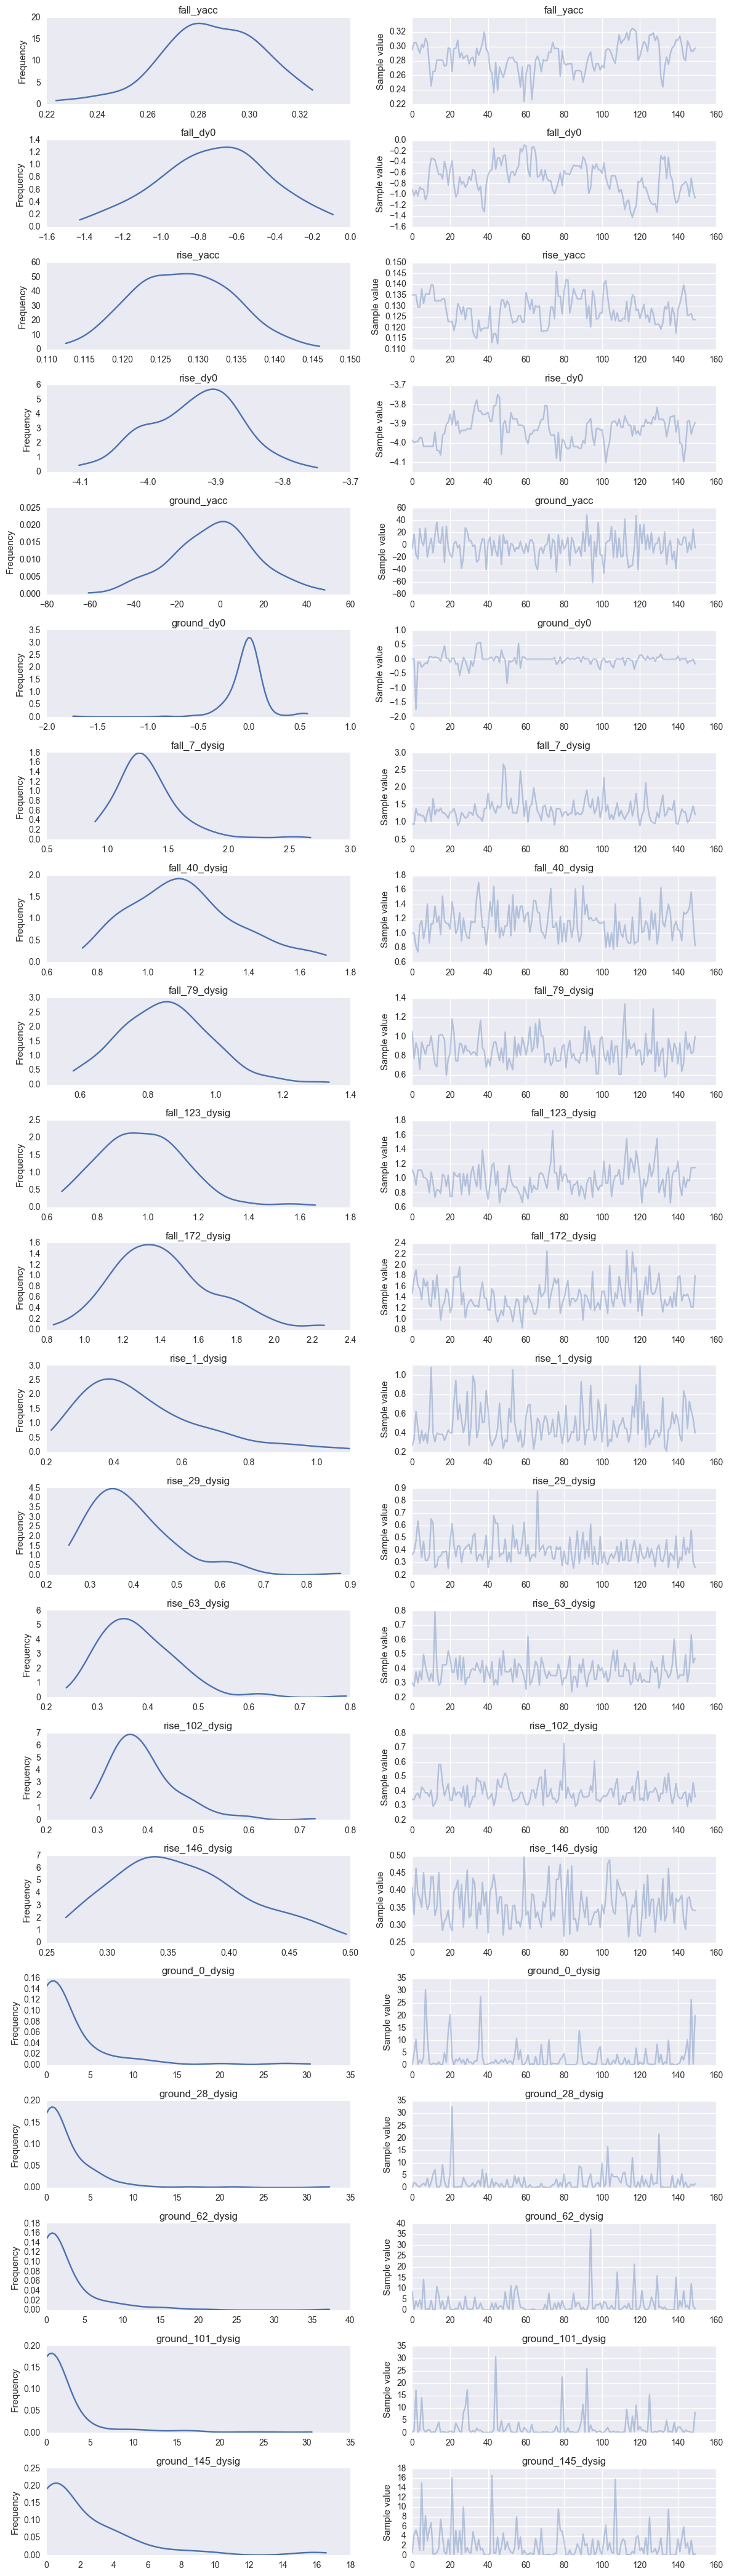

In [10]:
plt.figure(figsize=(6, 6))
pm.traceplot(trace[500:-1:10])
plt.tight_layout();

In [0]:
#pm.glm.plot_posterior_predictive(trace, eval=data["rx"], samples=100, label='posterior predictive regression lines')
#plt.plot(data["rx"], data["ry"])

In [0]:
# modelnm = "M"
# datamodelnm = "M"
# npoints = 100
# xc = "t"
# yc = "dy"
# mdl = model
# trc = pm.trace_to_dataframe(trace[-1000:])
# trc = trc[[xc,yc]]

# ordr = 1
# xlims = (0, t)

# x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
# pwrs = np.ones((npoints,ordr+1)) * np.arange(ordr+1)
# X = x ** pwrs
# cr = np.dot(X,trc.T)

# ## Calculate credible regions and plot over the datapoints
# dfp = pd.DataFrame(np.percentile(cr,[2.5, 25, 50, 75, 97.5], axis=1).T,
#                    columns=['025','250','500','750','975'])
# dfp['x'] = x

# pal = sns.color_palette('Greens')

# f, ax1d = plt.subplots(1,1, figsize=(7,7))
# f.suptitle('Posterior Predictive Fit -- Data: {} -- Model: {}'.format(
#     datamodelnm, modelnm), fontsize=16)
# plt.subplots_adjust(top=0.95)
# ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
#                   ,color=pal[1], label='CR 95%')
# ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.5
#                   ,color=pal[2], label='CR 50%')
# ax1d.plot(dfp['x'], dfp['500'], alpha=0.6, color=pal[4], label='Median')
# _ = plt.legend()
# _ = ax1d.set_xlim(xlims)
# _ = sns.regplot(x=xc, y=yc, data=data, fit_reg=False
#                 ,scatter_kws={'alpha':0.7,'s':100, 'lw':2,'edgecolor':'w'}, ax=ax1d)


In [0]:
pm.stats.dic(model=model,trace=trace)
